<a href="https://colab.research.google.com/github/yosef2000138/SENRAT/blob/main/start_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install transformers torch pandas numpy yfinance feedparser scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.0 MB/s eta 0:00:00


In [2]:

import pandas as pd, numpy as np
from datetime import timezone
import pytz
from transformers import pipeline, AutoTokenizer
import yfinance as yf
import feedparser
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from joblib import dump, load

# Your timezone (Israel)
LOCAL_TZ = "Asia/Jerusalem"
pd.set_option('display.max_columns', 120)


In [3]:

# Choose one FinBERT model
# model_id = "ProsusAI/finbert"            # labels: negative/neutral/positive
model_id = "yiyanghkust/finbert-tone"      # labels: positive/neutral/negative

clf = pipeline("text-classification", model=model_id, tokenizer=model_id,
               return_all_scores=True, truncation=True)
tok = AutoTokenizer.from_pretrained(model_id)
print("FinBERT ready:", model_id)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


FinBERT ready: yiyanghkust/finbert-tone


In [5]:

def chunk_by_tokens(text, tokenizer, max_tokens=480):
    toks = tokenizer(text, truncation=False, add_special_tokens=False)["input_ids"]
    chunks = [toks[i:i+max_tokens] for i in range(0, len(toks), max_tokens)] or [[]]
    return [tokenizer.decode(c, skip_special_tokens=True) for c in chunks]

def finbert_article(text, pipe, tokenizer):
    parts = chunk_by_tokens(text, tokenizer)
    scored = pipe(parts, truncation=True, padding=True)
    agg = {}
    for part_scores in scored:
        for d in part_scores:
            agg[d["label"].lower()] = agg.get(d["label"].lower(), 0.0) + d["score"]
    for k in agg: agg[k] /= max(len(scored), 1)
    top_label = max(agg.items(), key=lambda kv: kv[1])[0] if agg else "neutral"
    return top_label, agg

def finbert_batch(texts, pipe, batch_size=32):
    rows = []
    for i in range(0, len(texts), batch_size):
        batch = list(texts[i:i+batch_size])
        batch_scores = pipe(batch, truncation=True)
        for s in batch_scores:
            probs = {d["label"].lower(): d["score"] for d in s}
            top = max(s, key=lambda d: d["score"])
            rows.append({"label": top["label"].lower()} | probs)
    return pd.DataFrame(rows)



In [18]:

# You can replace with your own CSV: columns [time, open, high, low, close, volume]
# Example with Yahoo Finance (BTC-USD hourly for 120 days)
asset = "BTC-USD"
px = yf.download(asset, interval="60m", period="360D").rename(columns=str.lower)
px.index = pd.to_datetime(px.index, utc=True).tz_convert(LOCAL_TZ)
px = px[['open','high','low','close','volume']]
px.head()


/tmp/ipython-input-458033654.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(asset, interval="60m", period="360D").rename(columns=str.lower)
[*********************100%***********************]  1 of 1 completed


Price,open,high,low,close,volume
Ticker,btc-usd,btc-usd,btc-usd,btc-usd,btc-usd
Datetime,,,,,
2024-11-08 02:00:00+02:00,75900.031250,76366.664062,75900.031250,76078.265625,0
2024-11-08 03:00:00+02:00,76068.281250,76369.492188,75913.289062,76024.687500,0
2024-11-08 04:00:00+02:00,76047.320312,76047.320312,75726.687500,75751.398438,0
2024-11-08 05:00:00+02:00,75751.726562,75942.070312,75687.859375,75933.507812,0
2024-11-08 06:00:00+02:00,75940.570312,76067.265625,75899.484375,75899.484375,0


In [19]:
feeds = [
    "https://feeds.a.dj.com/rss/RSSMarketsMain.xml",
    "https://www.investing.com/rss/news_25.rss",
]

items = []
for u in feeds:
    feed = feedparser.parse(u)
    for e in feed.entries[:100]:
        # prefer 'published', fallback to 'updated', else None
        when = e.get("published") or e.get("updated")
        items.append({
            "time": pd.to_datetime(when, errors="coerce"),
            "title": e.get("title", "") or "",
            "summary": e.get("summary", "") or "",
        })

news_raw = pd.DataFrame(items).dropna(subset=["time"])

# Ensure tz-aware in UTC then convert to LOCAL_TZ (Series => use .dt)
s = pd.to_datetime(news_raw["time"], errors="coerce")
if s.dt.tz is None:
    s = s.dt.tz_localize("UTC")
news_raw["time"] = s.dt.tz_convert(LOCAL_TZ)

# Combine text fields
news_raw["text"] = (
    news_raw["title"].fillna("") + ". " + news_raw["summary"].fillna("")
).str.strip()

# Sort by time ascending (oldest -> newest); use ascending=False for newest first
news_raw = news_raw.sort_values("time", ascending=True)

# Peek
news_raw.head()

,time,title,summary,text
19,2025-01-25 12:30:00+02:00,Trump Adds Fuel to Claims That Big Banks Discr...,The president has told Bank of America and JPM...,Trump Adds Fuel to Claims That Big Banks Discr...
18,2025-01-26 04:00:00+02:00,"One House, Three Owners: The Ballooning Cost o...",The story of home affordability in the U.S. to...,"One House, Three Owners: The Ballooning Cost o..."
17,2025-01-26 07:01:00+02:00,"In China, a Cat-and-Mouse Game to Rein In Crypto",Recent court cases reveal how middlemen are fa...,"In China, a Cat-and-Mouse Game to Rein In Cryp..."
16,2025-01-26 12:30:00+02:00,Now Wanted in Silicon Valley: Ho-Hum Businesse...,Venture-capital firms are bringing AI and deal...,Now Wanted in Silicon Valley: Ho-Hum Businesse...
15,2025-01-26 13:00:00+02:00,What Will It Take for Home Buyers to Start Ask...,The real costs of owning a house in neighborho...,What Will It Take for Home Buyers to Start Ask...


In [20]:

df = news_raw.copy()
scores = finbert_batch(df["text"].fillna(""), clf)
df = pd.concat([df.reset_index(drop=True), scores.reset_index(drop=True)], axis=1)
df[["time","title","label","positive","neutral","negative"]].head()


,time,title,label,positive,neutral,negative
0,2025-01-25 12:30:00+02:00,Trump Adds Fuel to Claims That Big Banks Discr...,positive,0.965025,0.008500,0.026475
1,2025-01-26 04:00:00+02:00,"One House, Three Owners: The Ballooning Cost o...",neutral,0.001237,0.998051,0.000712
2,2025-01-26 07:01:00+02:00,"In China, a Cat-and-Mouse Game to Rein In Crypto",negative,0.000195,0.002365,0.997440
3,2025-01-26 12:30:00+02:00,Now Wanted in Silicon Valley: Ho-Hum Businesse...,negative,0.000050,0.001422,0.998527
4,2025-01-26 13:00:00+02:00,What Will It Take for Home Buyers to Start Ask...,negative,0.000183,0.204431,0.795386


In [21]:
import pandas as pd

# --- Choose frequency (use lower-case to avoid FutureWarning) ---
freq = "1h"  # align with price bars

# --- Ensure px has a proper datetime index and expected columns ---
px_ = px.copy()

# If time is a column, move it to the index
if "time" in px_.columns:
    px_["time"] = pd.to_datetime(px_["time"], errors="coerce", utc=True)
    px_ = px_.dropna(subset=["time"]).set_index("time")

# Ensure DateTimeIndex, sorted
px_.index = pd.to_datetime(px_.index, errors="coerce", utc=True)
px_ = px_.sort_index()

# Normalize column names to lowercase so 'Open'/'open' both work
px_ = px_.rename(columns=str.lower)

# If you truly have OHLCV columns, resample directly; otherwise derive OHLC from a single price column
have_ohlc = {"open", "high", "low", "close"}.issubset(px_.columns)
have_volume = "volume" in px_.columns

if have_ohlc:
    agg_map = {"open": "first", "high": "max", "low": "min", "close": "last"}
    if have_volume:
        agg_map["volume"] = "sum"
    bars = px_.resample(freq).agg(agg_map).dropna()
else:
    # derive OHLC from a single price column (prefer 'close', then 'price', else first numeric)
    if "close" in px_.columns:
        p = px_["close"]
    elif "price" in px_.columns:
        p = px_["price"]
    else:
        num_cols = px_.select_dtypes(include="number").columns
        if len(num_cols) == 0:
            raise ValueError("No numeric price column found in px.")
        p = px_[num_cols[0]]
    bars = p.resample(freq).ohlc().dropna()
    if have_volume:
        bars["volume"] = px_["volume"].resample(freq).sum()

# --- Sentiment resample & align ---
df_ = df.copy()
df_["time"] = pd.to_datetime(df_["time"], errors="coerce", utc=True)
df_ = df_.dropna(subset=["time"]).set_index("time").sort_index()

for c in ["positive", "neutral", "negative"]:
    if c not in df_.columns:
        df_[c] = 0.0

sent = (
    df_[["positive", "neutral", "negative"]]
    .resample(freq).mean()
    .reindex(bars.index)
    .fillna(0.0)
)

sent["sent_net"] = sent["positive"] - sent["negative"]
sent["sent_intensity"] = sent[["positive", "negative"]].max(axis=1)

for w in [3, 6, 12, 24]:
    sent[f"sent_net_ma{w}"] = sent["sent_net"].rolling(w, min_periods=1).mean()


In [22]:
# Fix columns before using them
if isinstance(bars.columns, pd.MultiIndex):
    bars.columns = [c[-1].lower() for c in bars.columns]
else:
    bars.columns = [c.lower() for c in bars.columns]

bars = bars.rename(columns={
    "price_open": "open",
    "price_high": "high",
    "price_low": "low",
    "price_close": "close"
})

if "volume" not in bars.columns:
    bars["volume"] = 0.0

# Now your original code
vwap = ((bars["close"] * bars["volume"]).cumsum() / bars["volume"].cumsum()).rename("vwap")

fe = pd.DataFrame(index=bars.index)
fe["ret_1"]  = roc(bars["close"], 1)
fe["ret_3"]  = roc(bars["close"], 3)
fe["ret_6"]  = roc(bars["close"], 6)
fe["ma_fast"] = sma(bars["close"], 10)
fe["ma_slow"] = sma(bars["close"], 30)
fe["ma_spread"] = fe["ma_fast"] - fe["ma_slow"]
fe["rsi14"] = rsi(bars["close"], 14)
fe["hl_spread"] = (bars["high"] - bars["low"]) / bars["close"]
fe["vwap"] = vwap
fe["close_vs_vwap"] = (bars["close"] - vwap) / vwap
fe["volume_z"] = (bars["volume"] - bars["volume"].rolling(30).mean()) / (bars["volume"].rolling(30).std() + 1e-12)

X = fe.join(sent, how="left").fillna(0.0)
X.head()


,ret_1,ret_3,ret_6,ma_fast,ma_slow,ma_spread,rsi14,hl_spread,vwap,close_vs_vwap,volume_z,positive,neutral,negative,sent_net,sent_intensity,sent_net_ma3,sent_net_ma6,sent_net_ma12,sent_net_ma24
Datetime,,,,,,,,,,,,,,,,,,,,
2024-11-08 00:00:00+00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08 01:00:00+00:00,-0.000704,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08 02:00:00+00:00,-0.003595,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08 03:00:00+00:00,0.002404,-0.001903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08 04:00:00+00:00,-0.000448,-0.001647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:

h = 3   # predict next 3 bars
future_price = bars["close"].shift(-h)
future_ret = (future_price / bars["close"]) - 1.0
thr = 0.001  # 0.1%

y = pd.Series(0, index=bars.index)
y[future_ret >  thr] = 1
y[future_ret < -thr] = -1

data = X.join(y.rename("y")).dropna()
Xmodel = data.drop(columns=["y"])
ytarget = data["y"]
print(data.shape, Xmodel.shape, ytarget.value_counts())


(8617, 21) (8617, 20) y
 1    3735
-1    3500
 0    1382
Name: count, dtype: int64


In [24]:

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=1000))
])

tscv = TimeSeriesSplit(n_splits=5)
reports = []
for i, (tr, te) in enumerate(tscv.split(Xmodel)):
    pipe.fit(Xmodel.iloc[tr], ytarget.iloc[tr])
    pred = pipe.predict(Xmodel.iloc[te])
    print(f"\nFold {i+1}")
    print(classification_report(ytarget.iloc[te], pred, digits=3))



Fold 1
              precision    recall  f1-score   support

          -1      0.465     0.315     0.375       613
           0      0.000     0.000     0.000       194
           1      0.450     0.730     0.556       629

    accuracy                          0.454      1436
   macro avg      0.305     0.348     0.311      1436
weighted avg      0.395     0.454     0.404      1436


Fold 2
              precision    recall  f1-score   support

          -1      0.444     0.033     0.061       606
           0      0.000     0.000     0.000       197
           1      0.443     0.973     0.609       633

    accuracy                          0.443      1436
   macro avg      0.296     0.335     0.223      1436
weighted avg      0.383     0.443     0.294      1436


Fold 3
              precision    recall  f1-score   support

          -1      0.417     0.880     0.566       573
           0      0.000     0.000     0.000       252
           1      0.579     0.216     0.315       6

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 4
              precision    recall  f1-score   support

          -1      0.398     0.844     0.541       565
           0      0.000     0.000     0.000       291
           1      0.456     0.186     0.264       580

    accuracy                          0.407      1436
   macro avg      0.285     0.343     0.268      1436
weighted avg      0.341     0.407     0.320      1436


Fold 5
              precision    recall  f1-score   support

          -1      0.393     0.641     0.488       566
           0      0.000     0.000     0.000       265
           1      0.452     0.383     0.415       605

    accuracy                          0.414      1436
   macro avg      0.282     0.342     0.301      1436
weighted avg      0.346     0.414     0.367      1436



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Final equity: 1.411340235581427
Sharpe (approx, hourly): 0.8288220134314254


<Axes: title={'center': 'Equity Curve (Hourly)'}, xlabel='Datetime'>

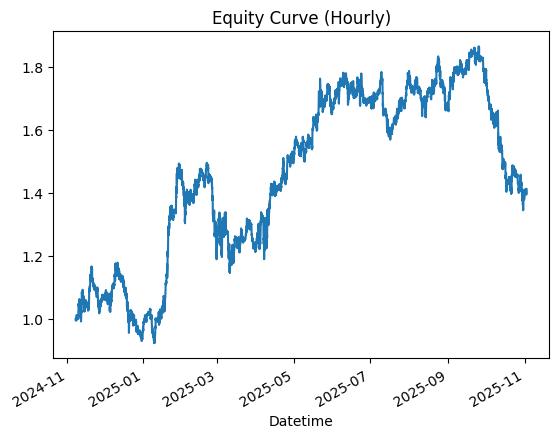

In [25]:

pipe.fit(Xmodel, ytarget)
signals = pd.Series(pipe.predict(Xmodel), index=Xmodel.index).rename("signal")
pos = signals.shift(1).fillna(0)
ret = bars["close"].pct_change().reindex(pos.index).fillna(0)

tc_bps = 0.0005  # 5 bps per trade side
turnover = (pos != pos.shift(1)).astype(int)
strategy_ret = pos * ret - turnover * tc_bps

equity = (1 + strategy_ret).cumprod()
sharpe = (strategy_ret.mean() / (strategy_ret.std() + 1e-12)) * np.sqrt(252*24)  # hourly
print("Final equity:", float(equity.iloc[-1]))
print("Sharpe (approx, hourly):", float(sharpe))

equity.plot(title="Equity Curve (Hourly)")


In [17]:

dump(pipe, "sent_vwap_model.joblib")
Xmodel.tail(5).to_csv("features_sample.csv")
print("Saved: sent_vwap_model.joblib, features_sample.csv")


Saved: sent_vwap_model.joblib, features_sample.csv
